# Chapter6 The Method of Godunov for Non–linear Systems

## expansion to 3 dimension

In [22]:
import numpy as np
import torch
from IPython.display import display, clear_output
import pyvista as pv
import random
from godunov_euler import GodunovEuler3D


pv.set_jupyter_backend("static")   # 가장 안정적

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA device: NVIDIA GeForce GTX 1660 SUPER


In [ ]:
#Constant parameters
RESOLUTION = 100, 100, 100

X_DOMAIN = [0, 1]
Y_DOMAIN = [0, 1]
Z_DOMAIN = [0, 1]
T_DOMAIN = [0, 0.5]
DX = (X_DOMAIN[1] - X_DOMAIN[0]) / RESOLUTION[2]
DY = (Y_DOMAIN[1] - Y_DOMAIN[0]) / RESOLUTION[1]
DZ = (Z_DOMAIN[1] - Z_DOMAIN[0]) / RESOLUTION[0]

CFL_COEFFICIENT = 0.8
GAMMA = 1.4
TOL = 1e-6

DIAMETER = 0.2

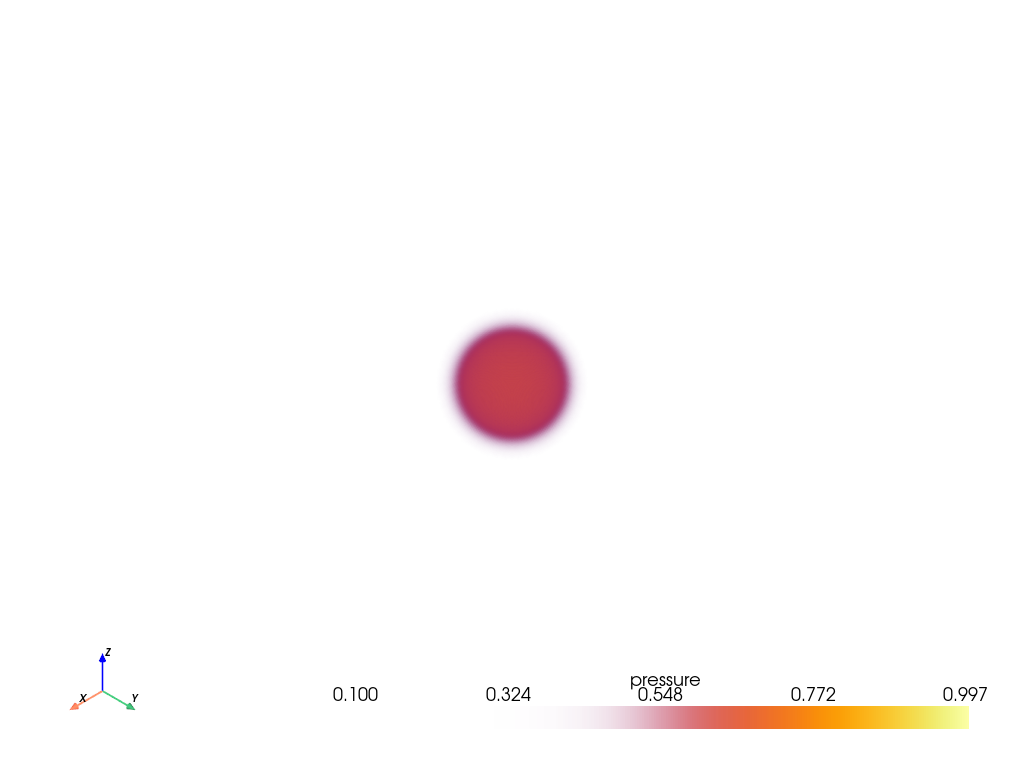

In [24]:
#Initial conditions - Explosion scenario
# +2 for cell boundary (ghost cells)
# Shape: (Nz + 2, Ny + 2, Nx + 2, 5) - [rho, u, v, w, p]
CELL = torch.zeros((RESOLUTION[0] + 2, RESOLUTION[1] + 2, RESOLUTION[2] + 2, 5), device=device)

# 중심 좌표 (도메인 중앙)
center_x = (X_DOMAIN[0] + X_DOMAIN[1]) / 2
center_y = (Y_DOMAIN[0] + Y_DOMAIN[1]) / 2
center_z = (Z_DOMAIN[0] + Z_DOMAIN[1]) / 2
radius = DIAMETER / 2  # 반경

# 각 셀의 중심 좌표 계산 (ghost cell 제외한 실제 셀만)
x_coords = torch.linspace(X_DOMAIN[0] + DX/2, X_DOMAIN[1] - DX/2, RESOLUTION[2], device=device)
y_coords = torch.linspace(Y_DOMAIN[0] + DY/2, Y_DOMAIN[1] - DY/2, RESOLUTION[1], device=device)
z_coords = torch.linspace(Z_DOMAIN[0] + DZ/2, Z_DOMAIN[1] - DZ/2, RESOLUTION[0], device=device)
X, Y, Z = torch.meshgrid(x_coords, y_coords, z_coords, indexing='xy')  # (Ny, Nx)

# 중심으로부터의 거리 계산
distances2 = (X - center_x)**2 + (Y - center_y)**2 + (Z - center_z)**2

# 기본값 설정 (외부 영역) - ghost cell 포함 전체
CELL[:, :, :, 0] = 0.125  # rho (low density)
CELL[:, :, :, 1] = 0.0    # u
CELL[:, :, :, 2] = 0.0    # v
CELL[:, :, :, 3] = 0.0    # w
CELL[:, :, :, 4] = 0.1    # p (low pressure)

sigma = 0.1
gaussian_profile = torch.exp(-distances2 / (2 * sigma**2))
# 폭발 영역 설정 (고압, 고밀도) - 실제 셀만 (ghost cell 제외)
CELL[1:-1, 1:-1, 1:-1, 0] += (1.0 - 0.125) * gaussian_profile   # rho (high density)
CELL[1:-1, 1:-1, 1:-1, 4] += (1.0 - 0.1) * gaussian_profile    # p (high pressure)

# Plot initial conditions as 3D scatter (subsampled)
rho_values = CELL[1:-1, 1:-1, 1:-1, 0].cpu().numpy()
u_values = CELL[1:-1, 1:-1, 1:-1, 1].cpu().numpy()
v_values = CELL[1:-1, 1:-1, 1:-1, 2].cpu().numpy()
w_values = CELL[1:-1, 1:-1, 1:-1, 3].cpu().numpy()
p_values = CELL[1:-1, 1:-1, 1:-1, 4].cpu().numpy()

grid = pv.ImageData() 

# VTK 규칙: cell data → dimensions = cell + 1
grid.dimensions = (RESOLUTION[2] + 1, RESOLUTION[1] + 1, RESOLUTION[0] + 1)
grid.spacing = (DX, DY, DZ)   # 격자 간격 
grid.origin = (X_DOMAIN[0], Y_DOMAIN[0], Z_DOMAIN[0])

grid.cell_data["density"]  = rho_values.flatten(order="F")
grid.cell_data["pressure"] = p_values.flatten(order="F")

velocity = np.stack(
    [u_values, v_values, w_values],
    axis=-1
)

grid.cell_data["velocity"] = velocity.reshape(-1, 3, order="F")

plotter = pv.Plotter()
plotter.add_volume(
    grid,
    scalars="pressure",
    cmap="inferno",
    opacity="sigmoid"
)
plotter.add_axes()
plotter.show()



In [25]:
# Initialize the solver
solver = GodunovEuler3D(
    num_cells_x=RESOLUTION[2],
    num_cells_y=RESOLUTION[1],
    num_cells_z=RESOLUTION[0],
    x_domain=X_DOMAIN,
    y_domain=Y_DOMAIN,
    z_domain=Z_DOMAIN,
    cfl_coefficient=CFL_COEFFICIENT,
    GAMMA=GAMMA,
    tol=TOL,
    device=device
)

CELL = solver.create_explosion_initial_condition()

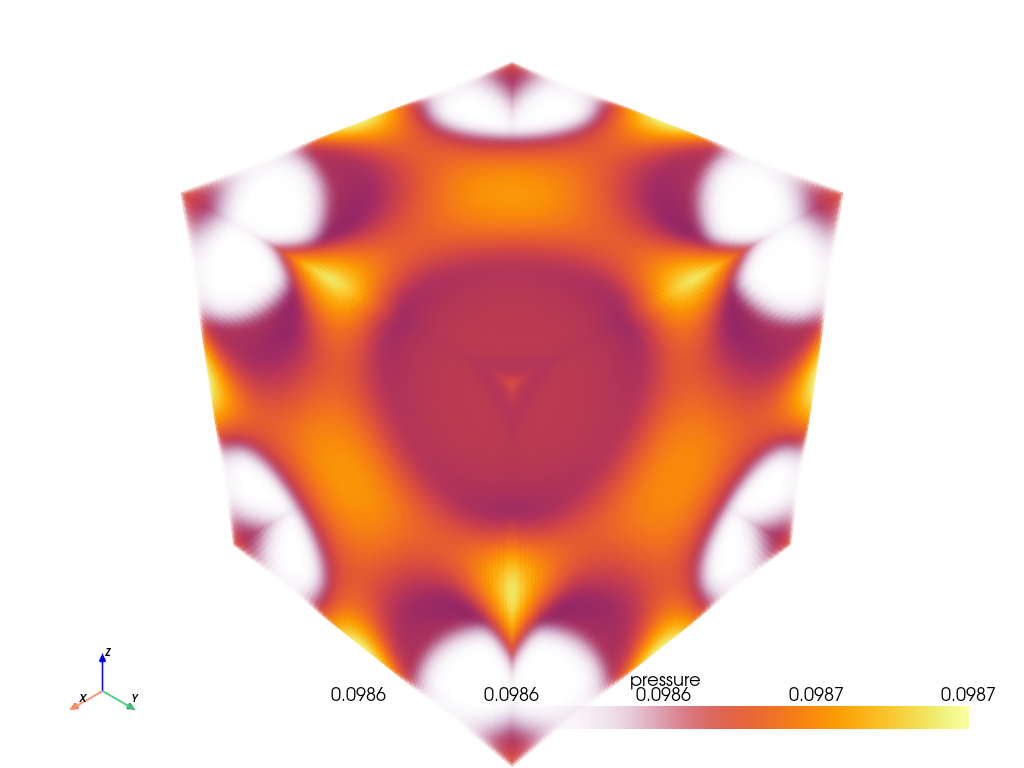

t = 2.938


In [ ]:
grid = pv.ImageData()

# VTK 규칙: cell data → dimensions = cell + 1 (x, y, z 순서)
grid.dimensions = (RESOLUTION[2] + 1, RESOLUTION[1] + 1, RESOLUTION[0] + 1)
grid.spacing = (DX, DY, DZ)
grid.origin = (X_DOMAIN[0], Y_DOMAIN[0], Z_DOMAIN[0])

# CELL(Z, Y, X) -> VTK(X, Y, Z) 축 정렬
rho = CELL[1:-1, 1:-1, 1:-1, 0].cpu().numpy()
speed = np.linalg.norm(CELL[1:-1, 1:-1, 1:-1, 1:4].cpu().numpy(), axis=-1)
pressure = CELL[1:-1, 1:-1, 1:-1, 4].cpu().numpy()

rho_vtk = np.transpose(rho, (2, 1, 0))
speed_vtk = np.transpose(speed, (2, 1, 0))
pressure_vtk = np.transpose(pressure, (2, 1, 0))

grid.cell_data["density"] = rho_vtk.flatten(order="F")
grid.cell_data["speed"] = speed_vtk.flatten(order="F")
grid.cell_data["pressure"] = pressure_vtk.flatten(order="F")

# plotter는 한 번만 생성
plotter = pv.Plotter(off_screen=True)
plotter.add_volume(grid, scalars="pressure", cmap="inferno", opacity="sigmoid")
plotter.add_axes()


t = T_DOMAIN[0]

while t < T_DOMAIN[1]:
    CELL, dt = solver.update(CELL)
    t += dt

    rho = CELL[1:-1, 1:-1, 1:-1, 0].cpu().numpy()
    speed = np.linalg.norm(CELL[1:-1, 1:-1, 1:-1, 1:4].cpu().numpy(), axis=-1)
    pressure = CELL[1:-1, 1:-1, 1:-1, 4].cpu().numpy()

    rho_vtk = np.transpose(rho, (2, 1, 0))
    speed_vtk = np.transpose(speed, (2, 1, 0))
    pressure_vtk = np.transpose(pressure, (2, 1, 0))

    grid.cell_data["density"][:] = rho_vtk.flatten(order="F")
    grid.cell_data["speed"][:] = speed_vtk.flatten(order="F")
    grid.cell_data["pressure"][:] = pressure_vtk.flatten(order="F")

    clear_output(wait=True)
    plotter.clear()
    plotter.add_volume(grid, scalars="pressure", cmap="inferno", opacity="sigmoid")
    plotter.add_axes()
    plotter.show(jupyter_backend="static")
    print(f"t = {t:.3f}")